# Flash ID validation 
Jupyter notebook to look at a PMT based neutrino ID for the LEE searches

### Imports

In [2]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import pickle
from matplotlib import colors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
from helpers import plot_class
from helpers import helpfunction as helper
import matplotlib.patches as patches

<IPython.core.display.Javascript object>

In [4]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [5]:
run = 2
indir = "./input/Jan2020/pickled/"
outdir = "./output/neutrinoID/run{}/".format(run)
mc_samples = ["nue", "nu", "dirt"]

<IPython.core.display.Javascript object>

### Load Data

In [6]:
%%time
in_file = open(indir + "data_run{}.pckl".format(run), "rb")
file_dict = pickle.load(in_file)
in_file.close()
in_file = open(indir + "mc_run{}.pckl".format(run), "rb")
file_dict.update(pickle.load(in_file))
in_file.close()

CPU times: user 566 ms, sys: 1.27 s, total: 1.83 s
Wall time: 3.42 s


<IPython.core.display.Javascript object>

In [7]:
pot_on = file_dict["on"]["pot"]
title_str = "{0:.2g} POT, Run{1}".format(pot_on, run)

<IPython.core.display.Javascript object>

In [8]:
# Add scale field to dict:
for tree in ["events", "slices", "flashes"]:
    # data scales
    num_obj = len(file_dict["on"][tree]["evt_time_sec"])
    file_dict["on"][tree]["scale"] = [1] * num_obj
    off_scale = file_dict["on"]["en1dcnt"] / file_dict["off"]["ext"]
    num_obj = len(file_dict["off"][tree]["evt_time_sec"])
    file_dict["off"][tree]["scale"] = [off_scale] * num_obj
    print("off", off_scale)
    # mc scales
    for sample in mc_samples:
        this_scale = file_dict["on"]["pot"] / file_dict[sample]["pot"]
        file_dict[sample][tree]["scale"] = (
            this_scale * file_dict[sample][tree]["weight"]
        )
        print(sample, this_scale)

off 2.6852727402370062
nue 0.004568598560665226
nu 2.157783853769299
dirt 1.3821448641163872
off 2.6852727402370062
nue 0.004568598560665226
nu 2.157783853769299
dirt 1.3821448641163872
off 2.6852727402370062
nue 0.004568598560665226
nu 2.157783853769299
dirt 1.3821448641163872


<IPython.core.display.Javascript object>

### Signal DataFrames

In [9]:
col_events = [
    "nFlashes",
    "nFlashesInBeamWindow",
    "hasBeamFlash",
    "nSlices",
    "nSlicesAfterPrecuts",
    "foundATargetSlice",
    "targetSliceMethod",
    "bestCosmicMatch",
    "cosmicMatchHypothesis",
    "bestCosmicMatchRatio",
    "nuEnergy",
    "nuVertexX",
    "nuVertexY",
    "nuVertexZ",
    "nueccinc",
    "numuccinc",
    "scale",
    "pure_selection",
    "weight",
]

col_slices = [
    "hasDeposition",
    "totalCharge",
    "centerX",
    "centerY",
    "centerZ",
    "deltaY",
    "deltaZ",
    "deltaYSigma",
    "deltaZSigma",
    "chargeToLightRatio",
    "xclVariable",
    "passesPreCuts",
    "flashMatchScore",
    "totalPEHypothesis",
    "isTaggedAsTarget",
    "targetMethod",
    "isConsideredByFlashId",
    "topologicalScore",
    "hasBestTopologicalScore",
    "hasBestFlashMatchScore",
    "nHits",
    "maxDeltaLLMCS",
    "lengthDeltaLLMCS",
    "purity",
    "completeness",
    "isMostComplete",
    "nuEnergy",
    "nuVertexX",
    "nuVertexY",
    "nuVertexZ",
    "nueccinc",
    "numuccinc",
    "scale",
    "pure_selection",
]

<IPython.core.display.Javascript object>

In [10]:
# make signal dataframes:
df_nue_sig = pd.DataFrame.from_dict(
    {
        k: file_dict["nue"]["events"][k]
        for k in col_events
        if k in file_dict["nue"]["events"]
    }
).query("nueccinc")

df_nu_sig = pd.DataFrame.from_dict(
    {
        k: file_dict["nu"]["events"][k]
        for k in col_events
        if k in file_dict["nu"]["events"]
    }
).query("numuccinc")

df_nue_slices_sig = pd.DataFrame.from_dict(
    {
        k: file_dict["nue"]["slices"][k]
        for k in col_slices
        if k in file_dict["nue"]["slices"]
    }
).query("nueccinc")

df_nu_slices_sig = pd.DataFrame.from_dict(
    {
        k: file_dict["nu"]["slices"][k]
        for k in col_slices
        if k in file_dict["nu"]["slices"]
    }
).query("numuccinc")

<IPython.core.display.Javascript object>

In [11]:
sig_events = {r"$\nu_e$ CC": df_nue_sig, r"$\nu_\mu$ CC": df_nu_sig}
sig_num = {
    r"$\nu_e$ CC": sum(df_nue_sig["scale"]),
    r"$\nu_\mu$ CC": sum(df_nu_sig["scale"]),
}
sig_slices = {r"$\nu_e$ CC": df_nue_slices_sig, r"$\nu_\mu$ CC": df_nu_slices_sig}

sig_dict = {
    r"$\nu_e$ CC": (sum(df_nue_sig["scale"]), df_nue_sig, df_nue_slices_sig),
    r"$\nu_\mu$ CC": (sum(df_nu_sig["scale"]), df_nu_sig, df_nu_slices_sig),
}

<IPython.core.display.Javascript object>

### Quick Checks

In [12]:
for k, (num_sig, df_sig, _) in sig_dict.items():
    print("\n###", k, "###")
    # average amount of slices before the neutrin id:
    nslices = df_sig.eval("nSlices*weight")
    passed = df_sig.eval("foundATargetSlice*weight")
    print(
        "Average number of slices at start: {:.2f}\nPassing fraction of slices: {:.1%}".format(
            nslices.mean(), passed.sum() / nslices.sum()
        )
    )

    eff, err = helper.effErr(
        df_sig.eval("nFlashesInBeamWindow*scale"), df_sig.eval("scale")
    )
    print(
        "Events with flash in window: ({0:.2f}+-{1:.2f})%".format(eff * 100, err * 100)
    )
    eff, err = helper.effErr(df_sig.eval("hasBeamFlash*scale"), df_sig.eval("scale"))
    print(
        "Events with 50PE flash in window: ({0:.2f}+-{1:.2f})%".format(
            eff * 100, err * 100
        )
    )
    eff, err = helper.effErr(
        df_sig.eval("(nSlicesAfterPrecuts>0)*scale"), df_sig.eval("scale")
    )
    print("Events passing precuts: ({0:.2f}+-{1:.2f})%".format(eff * 100, err * 100))
    eff, err = helper.effErr(
        df_sig.eval("foundATargetSlice*scale"), df_sig.eval("scale")
    )
    print(
        "Events passing optical selection: ({0:.2f}+-{1:.2f})%".format(
            eff * 100, err * 100
        )
    )
    eff, err = helper.effErr(df_sig.eval("pure_selection*scale"), df_sig.eval("scale"))
    print(
        "Events passing pure selection: ({0:.2f}+-{1:.2f})%".format(
            eff * 100, err * 100
        )
    )


### $\nu_e$ CC ###
Average number of slices at start: 4.44
Passing fraction of slices: 21.8%
Events with flash in window: (98.38+-0.08)%
Events with 50PE flash in window: (98.38+-0.08)%
Events passing precuts: (84.17+-0.22)%
Events passing optical selection: (83.37+-0.23)%
Events passing pure selection: (65.34+-0.30)%

### $\nu_\mu$ CC ###
Average number of slices at start: 4.48
Passing fraction of slices: 22.0%
Events with flash in window: (98.12+-0.13)%
Events with 50PE flash in window: (98.12+-0.13)%
Events passing precuts: (84.12+-0.35)%
Events passing optical selection: (83.51+-0.35)%
Events passing pure selection: (65.17+-0.43)%


<IPython.core.display.Javascript object>

In [14]:
for sample, data in file_dict.items():
    if sample in mc_samples:
        nslices = data["events"]["nSlices"] * data["events"]["weight"]
        passed = data["events"]["foundATargetSlice"] * data["events"]["weight"]
    else:
        nslices = data["events"]["nSlices"]
        passed = data["events"]["foundATargetSlice"]
    print(
        "{}: Average number of slices at start: {:.2f} \tPassing fraction of slices: {:.1%}".format(
            sample, np.mean(nslices), np.sum(passed) / np.sum(nslices)
        )
    )


### $\nu_e$ CC ###
Events where most complete slice passes the optical selection: (80.32+-0.25)%
80%+Pure/Complete slices passing the selection: (90.81+-0.19)%
80%+Pure/Complete reconstructed slice and passing the selection: (55.79+-0.29)%
Pure slices that are rejected by neutrino ID: (5.65+-0.12)%

### $\nu_\mu$ CC ###
Events where most complete slice passes the optical selection: (80.41+-0.37)%
80%+Pure/Complete slices passing the selection: (90.29+-0.31)%
80%+Pure/Complete reconstructed slice and passing the selection: (60.83+-0.44)%
Pure slices that are rejected by neutrino ID: (6.54+-0.22)%


<IPython.core.display.Javascript object>

In [13]:
file_dict["nue"]["events"].keys()

dict_keys(['run', 'subRun', 'event', 'evt_time_sec', 'evt_time_nsec', 'nFlashes', 'nFlashesInBeamWindow', 'hasBeamFlash', 'nSlices', 'nSlicesAfterPrecuts', 'foundATargetSlice', 'targetSliceMethod', 'bestCosmicMatch', 'cosmicMatchHypothesis', 'bestCosmicMatchRatio', 'nuMode', 'nuX', 'nuW', 'nuPt', 'nuTheta', 'nuCCNC', 'nuEnergy', 'leptonEnergy', 'nuInteractionTime', 'nuPdgCode', 'nuVertexX', 'nuVertexY', 'nuVertexZ', 'hash', 'reco_fidvol', 'pure_selection', 'weight', 'true_fidvol', 'nueccinc', 'numuccinc', 'scale'])

<IPython.core.display.Javascript object>

In [14]:
for sample, data in file_dict.items():
    if sample in mc_samples:
        nslices = data["events"]["nSlices"] * data["events"]["weight"]
        passed = data["events"]["foundATargetSlice"] * data["events"]["weight"]
    else:
        nslices = data["events"]["nSlices"]
        passed = data["events"]["foundATargetSlice"]
    print(
        "{}: Average number of slices at start: {:.2f} \tPassing fraction of slices: {:.1%}".format(
            sample, np.mean(nslices), np.sum(passed) / np.sum(nslices)
        )
    )

on: Average number of slices at start: 3.27 	Passing fraction of slices: 7.1%
off: Average number of slices at start: 3.21 	Passing fraction of slices: 4.6%
nue: Average number of slices at start: 4.43 	Passing fraction of slices: 20.6%
nu: Average number of slices at start: 3.84 	Passing fraction of slices: 12.8%
dirt: Average number of slices at start: 3.33 	Passing fraction of slices: 7.2%


<IPython.core.display.Javascript object>

In [15]:
selectors = [
    "nSlices",
    "nFlashes",
    "hasBeamFlash",
    "nSlicesAfterPrecuts",
    "foundATargetSlice",
    "reco_fidvol",
    "pure_selection",
]
for sel in selectors:
    print("\n###", sel, "###")
    for sample, data in file_dict.items():
        mask = data["events"][sel] > 0
        # print(mask)
        # print(data["events"]["scale"])
        nom = np.array(data["events"]["scale"])[mask]
        denom = sum(data["events"]["scale"])
        print("Passing percentage", sample, ": {0:.1f}%".format(sum(nom) * 100 / denom))
    r, _, r_err = helper.get_ratio(sel, file_dict)
    print("(on-off)/(BNB+dirt) = {:0.3f}+/-{:0.3f}".format(r, r_err))


### nSlices ###
Passing percentage on : 100.0%
Passing percentage off : 100.0%
Passing percentage nue : 100.0%
Passing percentage nu : 100.0%
Passing percentage dirt : 100.0%
on 	611674.0 events
off 	474767.0 events
nue 	311.2 events
nu 	144287.8 events
dirt 	53762.9 events
(on-off)/(BNB+dirt) = 0.691+/-0.004

### nFlashes ###
Passing percentage on : 94.5%
Passing percentage off : 93.2%
Passing percentage nue : 100.0%
Passing percentage nu : 86.5%
Passing percentage dirt : 85.1%
on 	578037.0 events
off 	442428.2 events
nue 	311.0 events
nu 	124761.4 events
dirt 	45775.0 events
(on-off)/(BNB+dirt) = 0.795+/-0.005

### hasBeamFlash ###
Passing percentage on : 75.8%
Passing percentage off : 69.8%
Passing percentage nue : 98.1%
Passing percentage nu : 79.9%
Passing percentage dirt : 73.1%
on 	463822.0 events
off 	331255.2 events
nue 	305.3 events
nu 	115341.9 events
dirt 	39289.6 events
(on-off)/(BNB+dirt) = 0.857+/-0.005

### nSlicesAfterPrecuts ###
Passing percentage on : 25.4%
Passing 

<IPython.core.display.Javascript object>

### Plots

#### Flash Plots

In [16]:
plotter = plot_class.Plotter(file_dict)

Initialisation done


<IPython.core.display.Javascript object>

In [17]:
print("Beam Windows")
beam_window = {}
for sample, data in file_dict.items():
    start = file_dict[sample]["metadata"]["beamWindowStart"][0]
    end = file_dict[sample]["metadata"]["beamWindowEnd"][0]
    beam_window[sample] = (start, end)
    print(sample, ": [", start, ",", end, "]")

# beam_window["on"] = [3.1871875, 3.1871875 + 1.68]

Beam Windows
on : [ 3.195 , 4.875 ]
off : [ 3.57 , 5.25 ]
nue : [ 3.57 , 5.25 ]
nu : [ 3.57 , 5.25 ]
dirt : [ 3.57 , 5.25 ]


<IPython.core.display.Javascript object>

In [18]:
minBeamFlashPE = file_dict["nu"]["metadata"]["minBeamFlashPE"][0]
maxDeltaY = file_dict["nu"]["metadata"]["maxDeltaY"][0]
maxDeltaZ = file_dict["nu"]["metadata"]["maxDeltaZ"][0]
maxDeltaYSigma = file_dict["nu"]["metadata"]["maxDeltaYSigma"][0]
maxDeltaZSigma = file_dict["nu"]["metadata"]["maxDeltaZSigma"][0]
minChargeToLightRatio = file_dict["nu"]["metadata"]["minChargeToLightRatio"][0]
maxChargeToLightRatio = file_dict["nu"]["metadata"]["maxChargeToLightRatio"][0]

<IPython.core.display.Javascript object>

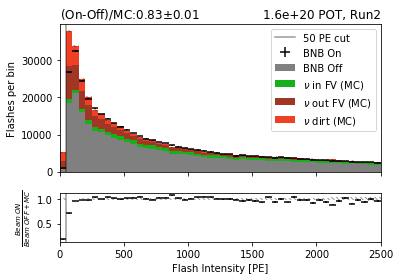

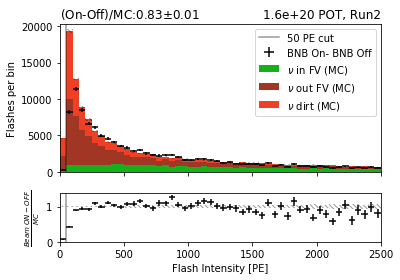

<IPython.core.display.Javascript object>

In [19]:
field = "totalPE"
fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
    "flashes",
    "totalPE",
    0,
    2500,
    50,
    x_lab="Flash Intensity [PE]",
    title_right=title_str,
    query="inBeamWindow",
)
for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
    lab = r"{:.0f} PE cut".format(minBeamFlashPE)
    ax[0].axvline(x=minBeamFlashPE, label=lab, color="k", alpha=0.4)
    ax[1].axvline(x=minBeamFlashPE, label=lab, color="k", alpha=0.4)
    ax[0].legend()
    fig.tight_layout()
    fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:289: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:303: RuntimeWarning: invalid value encountered in true_divide
  bins[2] / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:305: RuntimeWarning: invalid value encountered in true_divide
  yerr=bins_err[2] / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:425: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:439: RuntimeWarning: invalid value encountered in true_divide
  (bins[2] - bins[3]) / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:441: RuntimeWarning: invalid value encountered in true_divide
  yerr=np.sqrt(bins_err[2] ** 2 + bins_err[3] ** 2) / val,


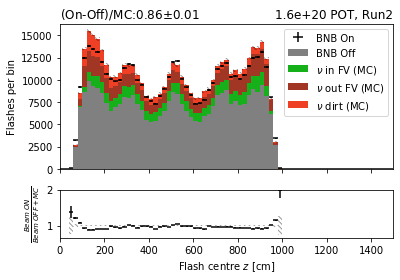

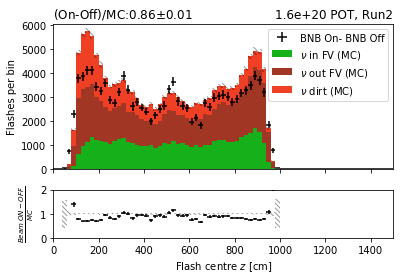

<IPython.core.display.Javascript object>

In [20]:
field = "centerZ"
fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
    "flashes",
    field,
    0,
    1500,
    75,
    x_lab=r"Flash centre $z$ [cm]",
    title_right=title_str,
    query="isBeamFlash",
)
for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
    ax[0].legend()
    fig.tight_layout()
    fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:289: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:303: RuntimeWarning: invalid value encountered in true_divide
  bins[2] / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:305: RuntimeWarning: invalid value encountered in true_divide
  yerr=bins_err[2] / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:425: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:439: RuntimeWarning: invalid value encountered in true_divide
  (bins[2] - bins[3]) / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:441: RuntimeWarning: invalid value encountered in true_divide
  yerr=np.sqrt(bins_err[2] ** 2 + bins_err[3] ** 2) / val,


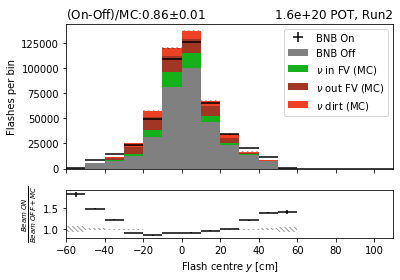

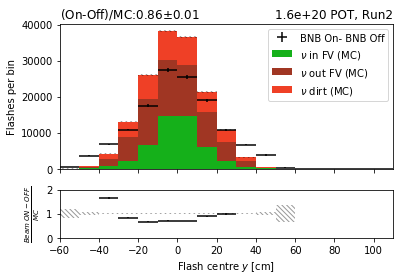

<IPython.core.display.Javascript object>

In [21]:
field = "centerY"
fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
    "flashes",
    field,
    -60,
    110,
    17,
    x_lab=r"Flash centre $y$ [cm]",
    title_right=title_str,
    query="isBeamFlash",
)
for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
    ax[0].legend()
    fig.tight_layout()
    fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in double_scalars
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:215: RuntimeWarning: invalid value encountered in true_divide


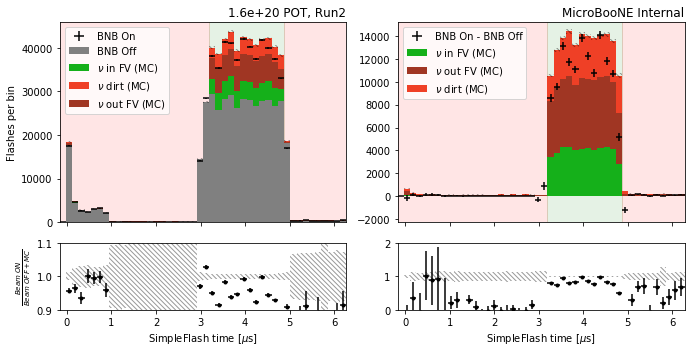

<IPython.core.display.Javascript object>

In [22]:
ksp  # Flash time plot
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(6 * plotter.gr, 5.0),
    gridspec_kw={"height_ratios": [3, 1]},
    sharex=True,
)

N = 46
x_min = beam_window["on"][0] - 0.28 * 12
x_max = 0.28 * 5 + beam_window["on"][1]
y_r_min = 0.9
y_r_max = 1.1

field = "time"
lab = r"SimpleFlash time [$\mu$s]"

# Correct time stamp
data = [
    np.array(file_dict[k]["flashes"][field])
    - (beam_window[k][0] - beam_window["on"][0])
    for k in plotter.dict_names
]
weights = [np.array(file_dict[k]["flashes"]["scale"]) for k in plotter.dict_names]
fid_mask = file_dict["nu"]["flashes"]["true_fidvol"] == 0
data.append(
    np.array(file_dict["nu"]["flashes"][field][fid_mask])
    - (beam_window["nu"][0] - beam_window["on"][0])
)
weights.append(np.array(file_dict["nu"]["flashes"]["scale"][fid_mask]))

edges, edges_mid, bins, max_val = plot_class.histHelper(
    N, x_min, x_max, data, weights=weights
)
bins_err = [
    plot_class.hist_bin_uncertainty(d_i, w_i, x_min, x_max, edges)
    for d_i, w_i in zip(data, weights)
]
widths = edges_mid - edges[:-1]


ax[0][0].axvspan(x_min, beam_window["on"][0], alpha=0.1, color="red")
ax[0][0].axvspan(beam_window["on"][0], beam_window["on"][1], alpha=0.1, color="green")
ax[0][0].axvspan(beam_window["on"][1], x_max, alpha=0.1, color="red")

# Data/MC
ax[0][0].errorbar(
    edges_mid,
    bins[2],
    xerr=widths,
    yerr=bins_err[2],
    color="k",
    fmt="none",
    label="BNB On",
)
ax[0][0].bar(edges_mid, bins[3], lw=2, label="BNB Off", width=2 * widths, color="grey")
ax[0][0].bar(
    edges_mid,
    bins[1],
    lw=2,
    label=r"$\nu$ in FV (MC)",
    width=2 * widths,
    bottom=bins[3],
    color="xkcd:green",
)
ax[0][0].bar(
    edges_mid,
    bins[4],
    lw=2,
    label=r"$\nu$ dirt (MC)",
    width=2 * widths,
    bottom=bins[1] + bins[3],
    color="xkcd:tomato",
)
ax[0][0].bar(
    edges_mid,
    bins[5],
    lw=2,
    label=r"$\nu$ out FV (MC)",
    width=2 * widths,
    bottom=bins[3] + bins[1] - bins[5],
    color="xkcd:brick",
)

y_err = np.sqrt(bins_err[1] ** 2 + bins_err[3] ** 2 + bins_err[4] ** 2)
val = bins[3] + bins[1] + bins[4]
for m, v, e, w in zip(edges_mid, val, y_err, widths):
    ax[0][0].add_patch(
        patches.Rectangle(
            (m - w, v - e),
            2 * w,
            2 * e,
            hatch="\\\\\\\\\\",
            Fill=False,
            linewidth=0,
            alpha=0.4,
        )
    )
    sc_err = e / v
    ax[1][0].add_patch(
        patches.Rectangle(
            (m - w, 1 - sc_err),
            2 * w,
            sc_err * 2,
            hatch="\\\\\\\\\\",
            Fill=False,
            linewidth=0,
            alpha=0.4,
        )
    )


# Ratio plots
ax[1][0].set_ylim(y_r_min, y_r_max)
ax[1][0].set_xlim(x_min, x_max)
ax[1][0].errorbar(
    edges_mid,
    bins[2] / val,
    xerr=widths,
    yerr=bins_err[2] / val,
    alpha=1.0,
    color="k",
    fmt=".",
    label="Data error",
)

ax[0][1].set_xlim(x_min, x_max)
ax[0][0].legend()
ax[1][0].set_xlabel(lab)
ax[0][0].set_ylabel("Flashes per bin")
ax[0][0].set_title(title_str, loc="right")


# On - Off:
ax[0][1].axvspan(x_min, beam_window["on"][0], alpha=0.1, color="red")
ax[0][1].axvspan(beam_window["on"][0], beam_window["on"][1], alpha=0.1, color="green")
ax[0][1].axvspan(beam_window["on"][1], x_max, alpha=0.1, color="red")

# Data/MC
ax[0][1].errorbar(
    edges_mid,
    bins[2] - bins[3],
    xerr=widths,
    yerr=np.sqrt(bins_err[2] ** 2 + bins_err[3] ** 2),
    color="k",
    fmt="none",
    label="BNB On - BNB Off",
)

ax[0][1].bar(
    edges_mid,
    bins[1],
    lw=2,
    label=r"$\nu$ in FV (MC)",
    width=2 * widths,
    color="xkcd:green",
)
ax[0][1].bar(
    edges_mid,
    bins[5],
    lw=2,
    label=r"$\nu$ out FV (MC)",
    width=2 * widths,
    bottom=bins[1] - bins[5],
    color="xkcd:brick",
)

ax[0][1].bar(
    edges_mid,
    bins[4],
    lw=2,
    label=r"$\nu$ dirt (MC)",
    width=2 * widths,
    bottom=bins[1],
    color="xkcd:tomato",
)
ax[0][1].legend()
ax[1][1].set_xlabel(lab)
ax[0][1].set_title("MicroBooNE Internal", loc="right")

ax[1][1].set_ylim(0, 2)
ax[1][1].set_xlim(x_min, x_max)

y_err = np.sqrt(bins_err[1] ** 2 + bins_err[4] ** 2)
val = bins[1] + bins[4]
for m, v, e, w in zip(edges_mid, val, y_err, widths):
    ax[0][1].add_patch(
        patches.Rectangle(
            (m - w, v - e),
            2 * w,
            2 * e,
            hatch="\\\\\\\\\\",
            Fill=False,
            linewidth=0,
            alpha=0.4,
        )
    )
    sc_err = e / v
    ax[1][1].add_patch(
        patches.Rectangle(
            (m - w, 1 - sc_err),
            2 * w,
            sc_err * 2,
            hatch="\\\\\\\\\\",
            Fill=False,
            linewidth=0,
            alpha=0.4,
        )
    )
ax[1][1].errorbar(
    edges_mid,
    (bins[2] - bins[3]) / val,
    xerr=widths,
    yerr=np.sqrt(bins_err[2] ** 2 + bins_err[3] ** 2) / val,
    alpha=1.0,
    color="k",
    fmt=".",
    label="Data error",
)


ax[1][0].set_ylabel(r"$\frac{Beam\ ON}{Beam\ OFF + MC}$")
fig.tight_layout()
fig.savefig(outdir + field + ".pdf", bbox_inches="tight")

### Event Plots

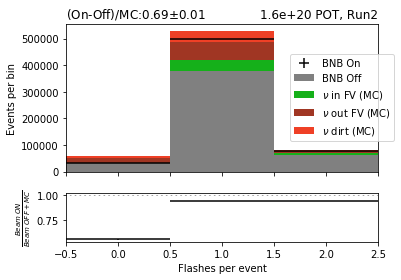

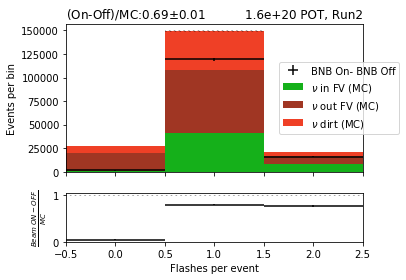

<IPython.core.display.Javascript object>

In [23]:
field = "nFlashes"
fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
    "events",
    field,
    -0.5,
    2.5,
    3,
    x_lab=r"Flashes per event",
    title_right=title_str,
    # query="hasBeamFlash",
)
for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
    ax[0].legend(bbox_to_anchor=(0.7, 0.5), loc="center left")
    fig.tight_layout()
    fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:425: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:439: RuntimeWarning: divide by zero encountered in true_divide
  (bins[2] - bins[3]) / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:441: RuntimeWarning: divide by zero encountered in true_divide
  yerr=np.sqrt(bins_err[2] ** 2 + bins_err[3] ** 2) / val,
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


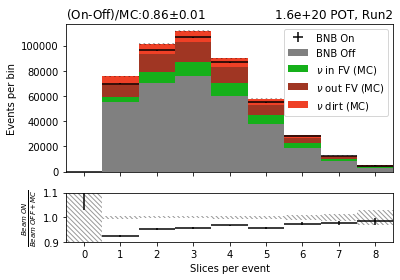

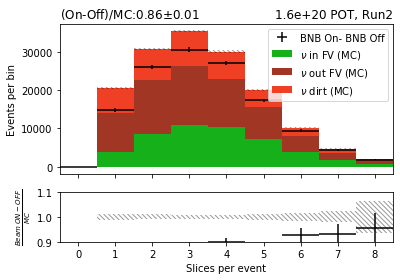

<IPython.core.display.Javascript object>

In [24]:
field = "nSlices"
fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
    "events",
    field,
    -0.5,
    8.5,
    9,
    x_lab=r"Slices per event",
    title_right=title_str,
    query="hasBeamFlash",
)
for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
    ax[0].legend(loc="upper right")
    ax[1].set_ylim(0.9, 1.1)
    fig.tight_layout()
    fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:289: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:303: RuntimeWarning: divide by zero encountered in true_divide
  bins[2] / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:303: RuntimeWarning: invalid value encountered in true_divide
  bins[2] / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:305: RuntimeWarning: divide by zero encountered in true_divide
  yerr=bins_err[2] / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:305: RuntimeWarning: invalid value encountered in true_divide
  yerr=bins_err[2] / val,
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_cl

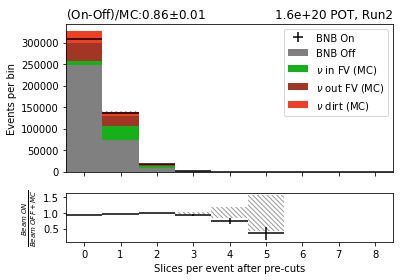

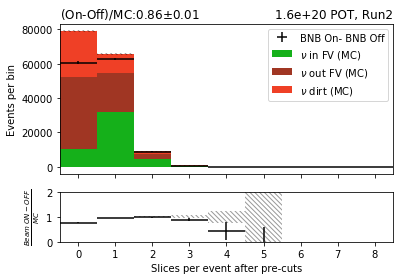

<IPython.core.display.Javascript object>

In [25]:
field = "nSlicesAfterPrecuts"
fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
    "events",
    field,
    -0.5,
    8.5,
    9,
    x_lab=r"Slices per event after pre-cuts",
    title_right=title_str,
    query="hasBeamFlash",
)
for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
    ax[0].legend(loc="upper right")
    fig.tight_layout()
    fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


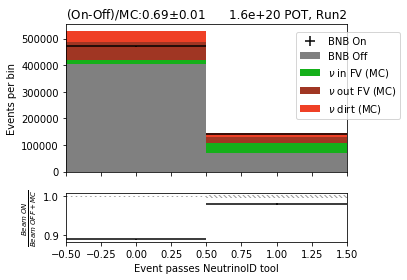

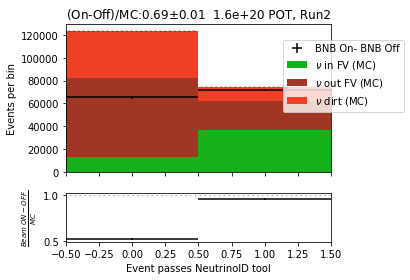

<IPython.core.display.Javascript object>

In [26]:
field = "foundATargetSlice"
fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
    "events",
    field,
    -0.5,
    1.5,
    2,
    x_lab=r"Event passes NeutrinoID tool",
    title_right=title_str,
)
for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
    ax[0].legend(bbox_to_anchor=(0.8, 0.65), loc="center left")
    fig.tight_layout()
    fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

#### Optical Pre-cuts Plots

In [27]:
# Plots
plot_fields_bin = [
    "deltaZ",
    "deltaZSigma",
    "deltaY",
    "deltaYSigma",
    "xclVariable",
]  #'ACPTdt']
plot_x_axis = [
    r"Charge $z$ - Flash $z$ [cm]",
    "(Charge $z$ - Flash $z$) / Flashwidth $z$",
    r"Charge $y$ - Flash $y$ [cm]",
    "(Charge $y$ - Flash $y$) / Flashwidth $y$",
    r"m$\cdot\log(\frac{Charge \: [ADC]}{Light \: [PE]})$ - Charge $x$ [cm]",
]

x_min_arr = [-200, -1.8, -120, -4.0, -400]
x_max_arr = [200, 1.4, 120, 4.0, 600]
bins_arr = [30, 30, 30, 30, 30]
cut_arr = [
    maxDeltaZ,
    maxDeltaZSigma,
    maxDeltaY,
    maxDeltaYSigma,
    [minChargeToLightRatio, maxChargeToLightRatio],
]

<IPython.core.display.Javascript object>

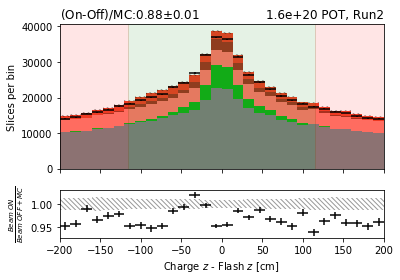

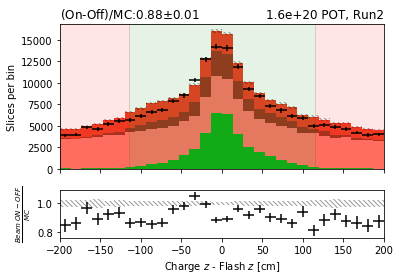

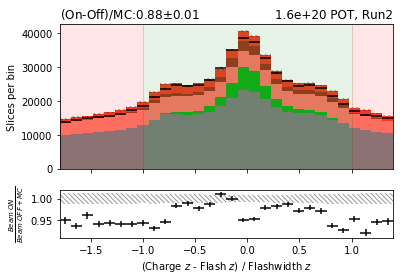

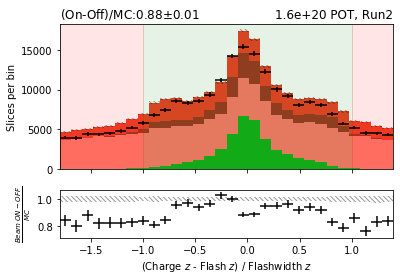

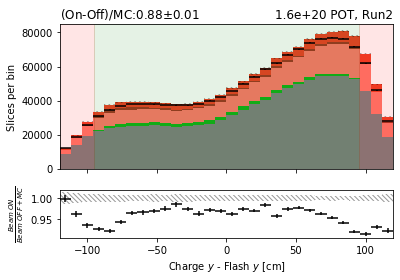

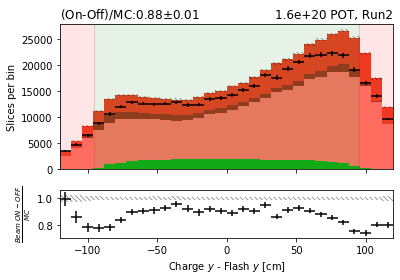

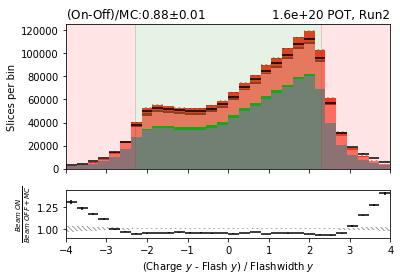

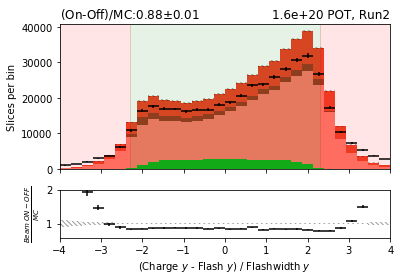

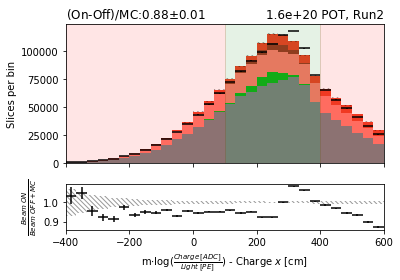

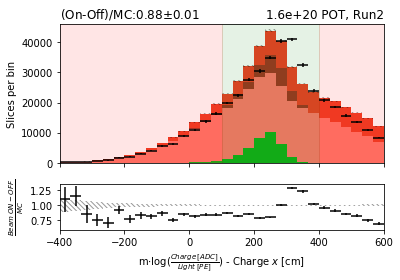

<IPython.core.display.Javascript object>

In [28]:
# Before any precuts, requiring a flash
for field, x_axis, x_min, x_max, bins, cut in zip(
    plot_fields_bin, plot_x_axis, x_min_arr, x_max_arr, bins_arr, cut_arr
):
    fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
        "slices",
        field,
        x_min,
        x_max,
        bins,
        x_lab=x_axis,
        title_right=title_str,
        query="isConsideredByFlashId",
    )
    for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
        if isinstance(cut, list):
            ax[0].axvspan(x_min, cut[0], alpha=0.1, color="red")
            ax[0].axvspan(cut[0], cut[1], alpha=0.1, color="green")
            ax[0].axvspan(cut[1], x_max, alpha=0.1, color="red")
        elif cut != 0:
            ax[0].axvspan(x_min, -cut, alpha=0.1, color="red")
            ax[0].axvspan(-cut, cut, alpha=0.1, color="green")
            ax[0].axvspan(cut, x_max, alpha=0.1, color="red")
        # ax[0].legend(bbox_to_anchor=(0.8, 0.65), loc="center left")
        fig.tight_layout()
        fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:289: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:303: RuntimeWarning: invalid value encountered in true_divide
  bins[2] / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:305: RuntimeWarning: invalid value encountered in true_divide
  yerr=bins_err[2] / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:425: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:439: RuntimeWarning: invalid value encountered in true_divide
  (bins[2] - bins[3]) / val,
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:441: RuntimeWarning: invalid value encountered in true_divide
  yerr=np.sqrt(bins_err[2] ** 2 + bins_err[3] ** 2) / val,


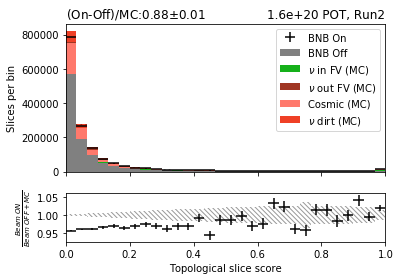

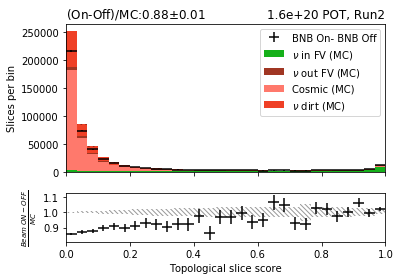

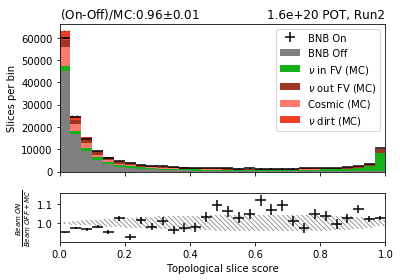

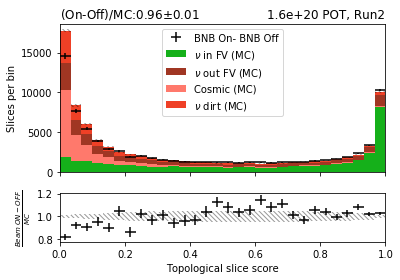

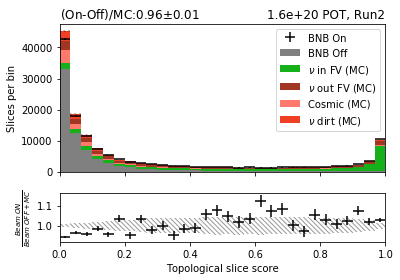

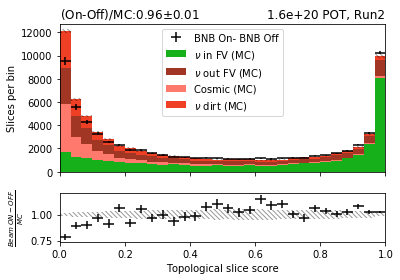

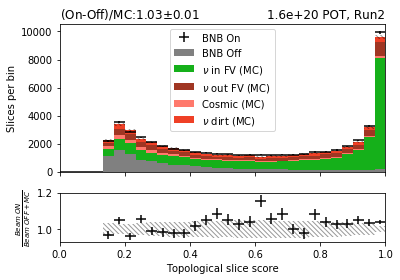

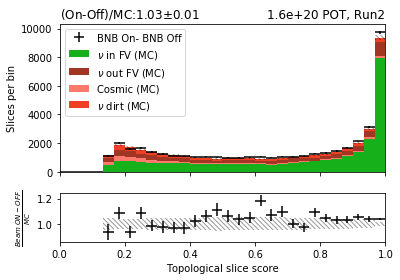

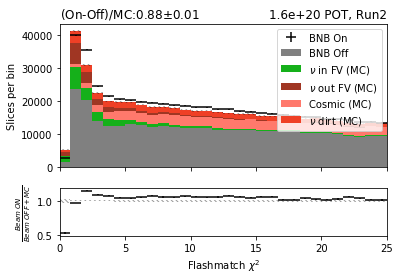

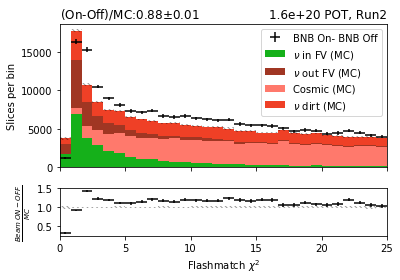

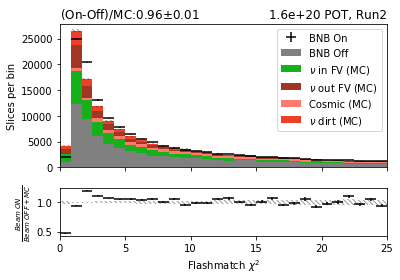

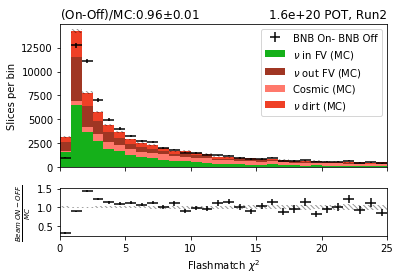

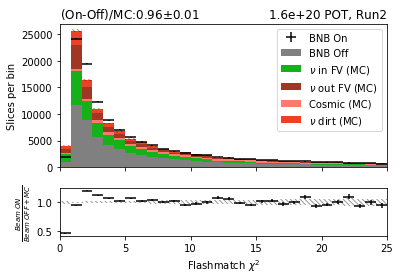

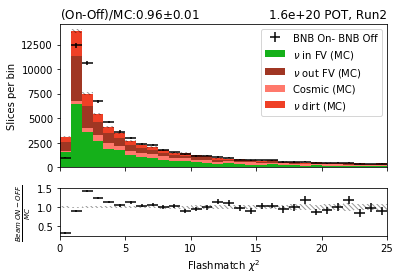

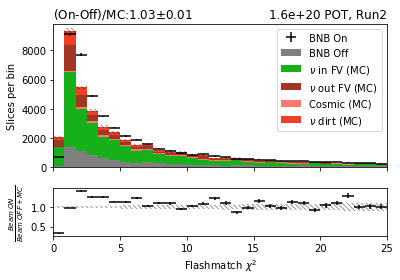

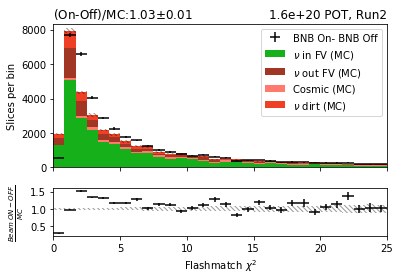

<IPython.core.display.Javascript object>

In [29]:
# Topo and flash chi2
queries = [
    "isConsideredByFlashId",
    "passesPreCuts",
    "isTaggedAsTarget",
    "pure_selection",
]
# Plots
plot_fields_bin = ["topologicalScore", "flashMatchScore"]
plot_x_axis = ["Topological slice score", r"Flashmatch $\chi^2$"]
x_min_arr = [0, 0]
x_max_arr = [1, 25]
bins_arr = [30, 30]

for field, x_axis, x_min, x_max, bins in zip(
    plot_fields_bin, plot_x_axis, x_min_arr, x_max_arr, bins_arr
):
    for query in queries:
        fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
            "slices",
            field,
            x_min,
            x_max,
            bins,
            x_lab=x_axis,
            title_right=title_str,
            query=query,
        )
        for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
            ax[0].legend()
            # ax[0].set_yscale("log")
            fig.tight_layout()
            fig.savefig(
                outdir + "{}{}_{}.pdf".format(field, name, query), bbox_inches="tight"
            )

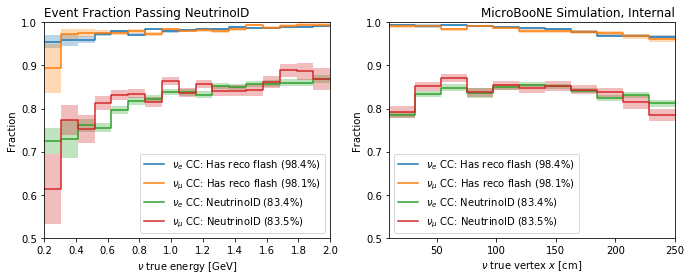

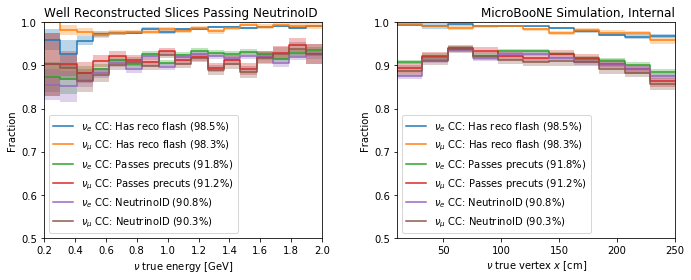

<IPython.core.display.Javascript object>

In [30]:
# Plot the efficiency in function of true neutrino energy:
# For events
fig, ax = plt.subplots(ncols=2, figsize=(6 * plotter.gr, 4))
field_arr = ["nuEnergy", "nuVertexX"]
N_arr = [18, 12]
x_min_arr = [0.2, 10]
x_max_arr = [2.0, 250]
label_arr = [r"$\nu$ true energy [GeV]", r"$\nu$ true vertex $x$ [cm]"]
arrays = [field_arr, N_arr, x_min_arr, x_max_arr, label_arr, ax]
queries = ["hasBeamFlash", "foundATargetSlice", "pure_selection"]
q_labs = ["Has reco flash", "NeutrinoID"]


for i, (field, bins, x_min, x_max, x_axis, ax_i) in enumerate(zip(*arrays)):
    for query, lab in zip(queries, q_labs):
        for k, v in sig_events.items():
            num = v.query(query)[field]
            num_w = v.query(query)["scale"]
            den = v[field]
            den_w = v["scale"]
            eff, unc_low, unc_up, edges = plot_class.efficiency_post(
                num, den, num_w, den_w, bins, x_min, x_max
            )
            this_lab = "{}: {} ({:0.1%})".format(k, lab, sum(num_w) / sum(den_w))
            ax_i.step(edges, eff, where="post", label=this_lab)
            ax_i.fill_between(
                edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post"
            )

    ax_i.set_xlabel(x_axis)
    ax_i.set_ylabel("Fraction")
    ax_i.set_xlim(x_min, x_max)
    ax_i.legend()
    ax_i.set_ylim(0.5, 1)
ax[0].set_title("Event Fraction Passing NeutrinoID", loc="left")
ax[1].set_title("MicroBooNE Simulation, Internal", loc="right")

fig.tight_layout()
fig.savefig(
    outdir + "passing_fraction_mc_signal_event.pdf".format(field, name, query),
    bbox_inches="tight",
)


# For Slices
fig, ax = plt.subplots(ncols=2, figsize=(6 * plotter.gr, 4))
arrays = [field_arr, N_arr, x_min_arr, x_max_arr, label_arr, ax]
queries = [
    "isConsideredByFlashId",
    "passesPreCuts",
    "isTaggedAsTarget",
    "pure_selection",
]
q_labs = ["Has reco flash", "Passes precuts", "NeutrinoID"]
clean_query = "purity>0.8 & completeness>0.8"
bad_query = "purity<0.8 & completeness<0.8"

for i, (field, bins, x_min, x_max, x_axis, ax_i) in enumerate(zip(*arrays)):
    for query, lab in zip(queries, q_labs):
        for k, v in sig_slices.items():
            view = v.query(clean_query)
            num = view.query(query)[field]
            num_w = view.query(query)["scale"]
            den = view[field]
            den_w = view["scale"]
            eff, unc_low, unc_up, edges = plot_class.efficiency_post(
                num, den, num_w, den_w, bins, x_min, x_max
            )
            this_lab = "{}: {} ({:0.1%})".format(k, lab, sum(num_w) / sum(den_w))
            ax_i.step(edges, eff, where="post", label=this_lab)
            ax_i.fill_between(
                edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post"
            )

    ax_i.set_xlabel(x_axis)
    ax_i.set_ylabel("Fraction")
    ax_i.set_xlim(x_min, x_max)
    ax_i.legend()
    ax_i.set_ylim(0.5, 1)
ax[0].set_title("Well Reconstructed Slices Passing NeutrinoID", loc="left")
ax[1].set_title("MicroBooNE Simulation, Internal", loc="right")

fig.tight_layout()
fig.savefig(
    outdir + "passing_fraction_mc_signal_slices.pdf".format(field, name, query),
    bbox_inches="tight",
)

#### Other Plots

[autoreload of helpers.plot_class failed: Traceback (most recent call last):
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    frame = next(frame_nfo.frame for frame_nfo in inspect.stack()
StopIteration
]


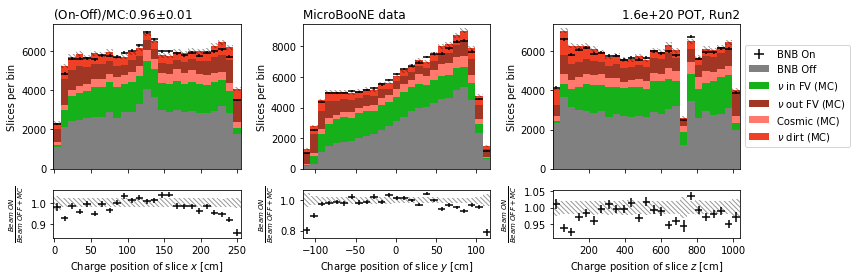

<IPython.core.display.Javascript object>

In [34]:
%autoreload
fig, axes = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(12, 4),
    gridspec_kw={"height_ratios": [3, 1]},
    sharex="col",
)

field_arr = ["centerX", "centerY", "centerZ"]
N_arr = [25, 25, 25, 25]
x_min_arr = [*helper.lower]
x_max_arr = [*helper.upper]
label_arr = [
    "Charge position of slice $x$ [cm]",
    "Charge position of slice $y$ [cm]",
    "Charge position of slice $z$ [cm]",
]
arrays = [field_arr, N_arr, x_min_arr, x_max_arr, label_arr, axes.T]
query = "isTaggedAsTarget"

t_bool = ["", "MicroBooNE data", " "]
t_string = ["", "", title_str]

for i, (field, bins, x_min, x_max, x_axis, ax_i) in enumerate(zip(*arrays)):
    ksp, ratio = plotter.data_mc_plot_add(
        "slices",
        field,
        x_min,
        x_max,
        bins,
        x_lab=x_axis,
        title_left=t_bool[i],
        title_right=t_string[i],
        query=query,
        ax=ax_i,
    )

axes[0][2].legend(bbox_to_anchor=(1, 0.5), loc="center left")
fig.tight_layout()
fig.savefig(outdir + "{}_{}.pdf".format("chargepos", query), bbox_inches="tight")

In [35]:
field_arr = ["totalCharge", "centerX", "centerY", "centerZ"]
N_arr = [25, 25, 25, 25]
x_min_arr = [0, *helper.lower]
x_max_arr = [100000, *helper.upper]
label_arr = [
    "Total charge per slice",
    "Charge position of slice $x$ [cm]",
    "Charge position of slice $y$ [cm]",
    "Charge position of slice $z$ [cm]",
]
arrays = [field_arr, N_arr, x_min_arr, x_max_arr, label_arr]

queries = [
    "isConsideredByFlashId",
    "passesPreCuts",
    "isTaggedAsTarget",
    "pure_selection",
]

<IPython.core.display.Javascript object>

/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:216: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  sharex="col",
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:356: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  sharex="col",
/home/wouter/Documents/Jupyter/neutrinoID/helpers/plot_class.py:216: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning

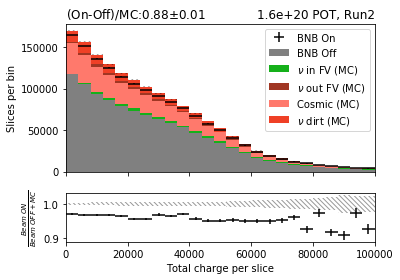

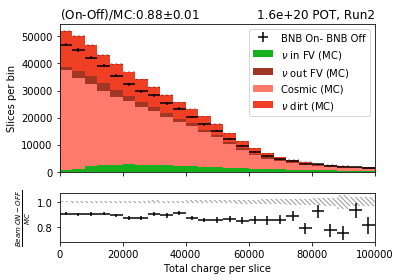

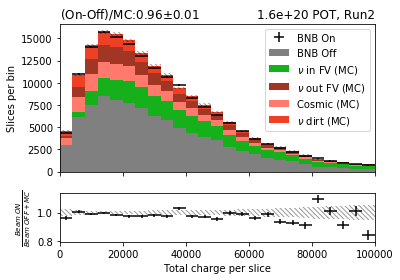

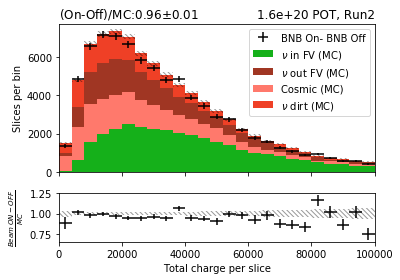

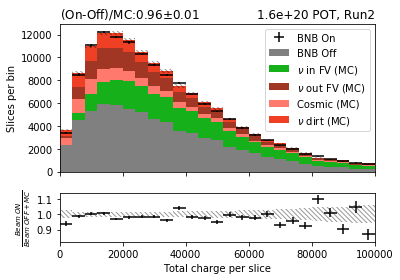

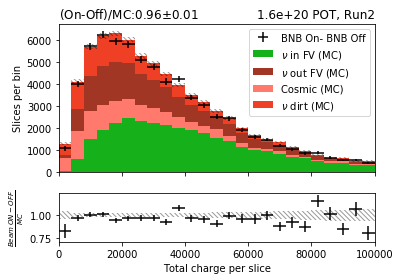

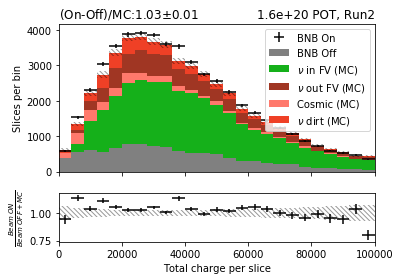

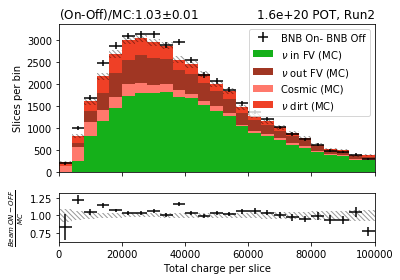

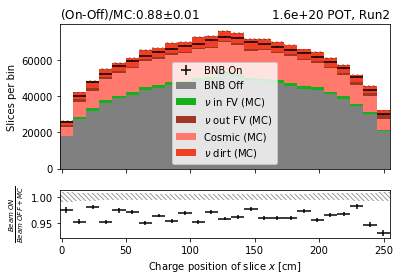

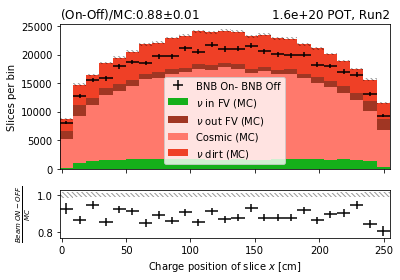

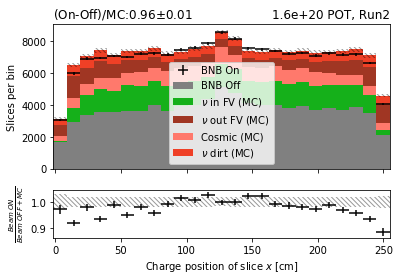

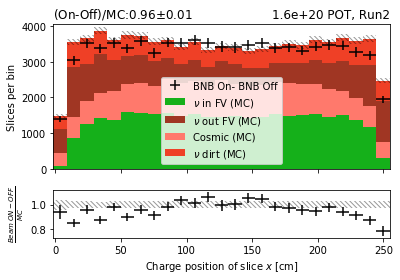

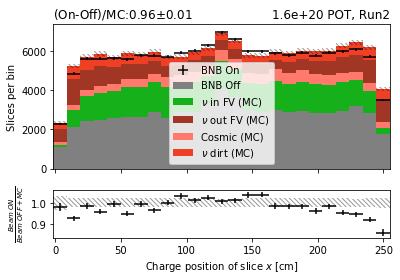

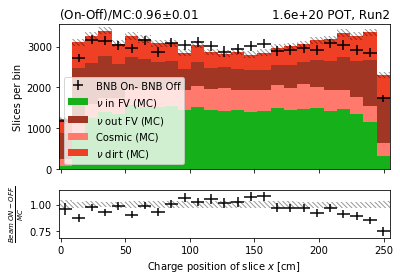

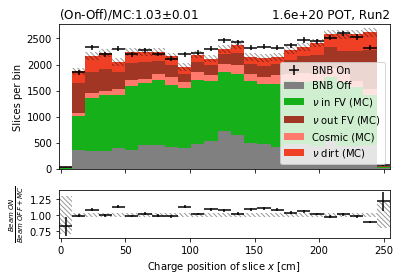

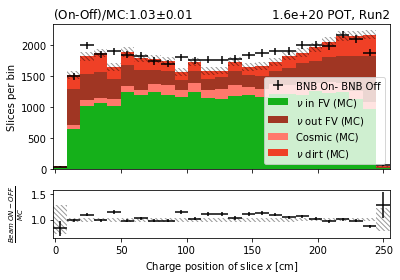

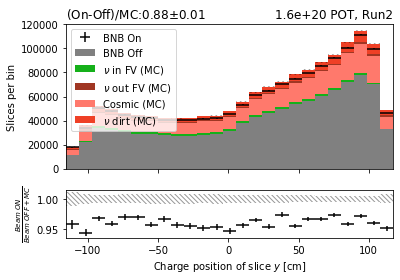

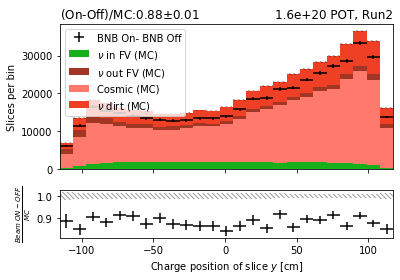

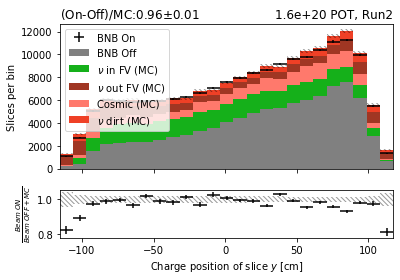

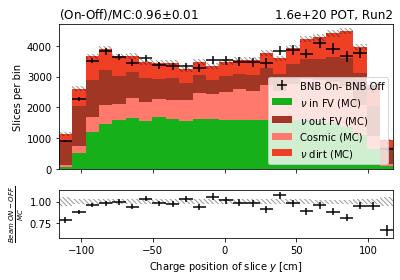

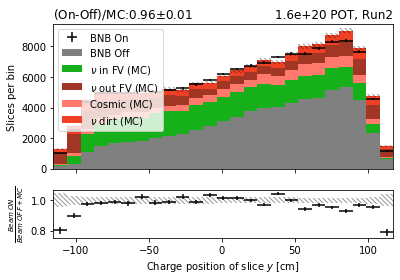

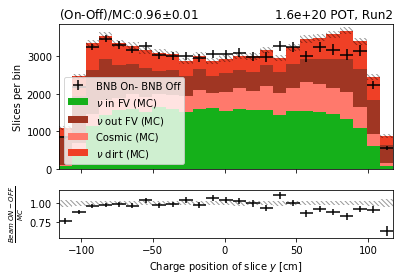

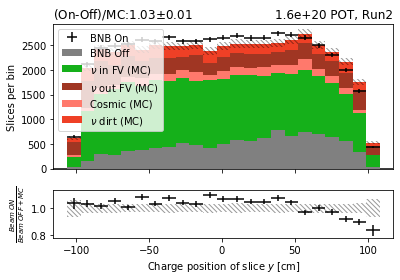

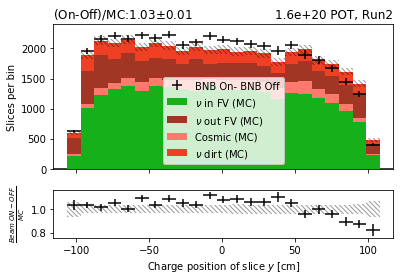

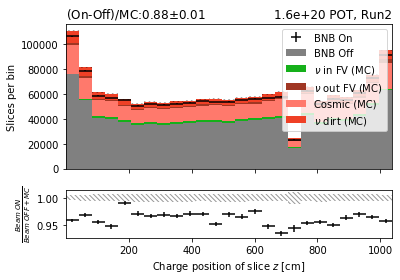

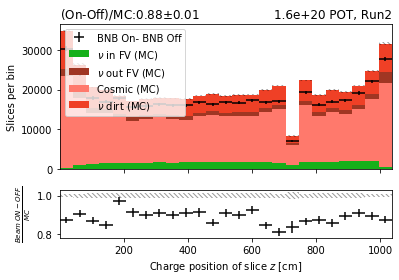

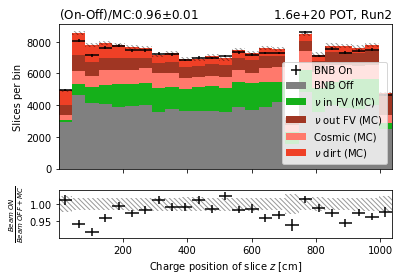

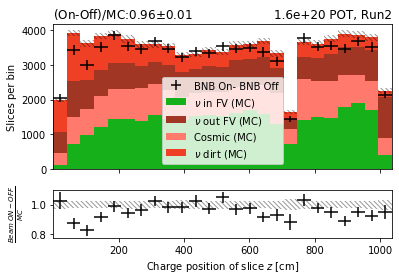

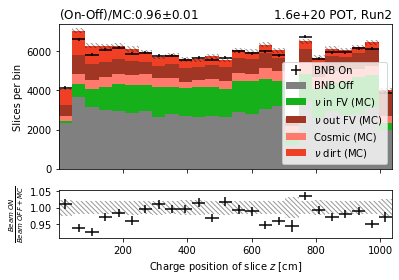

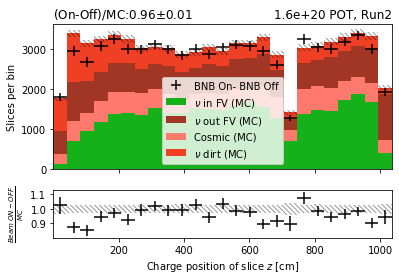

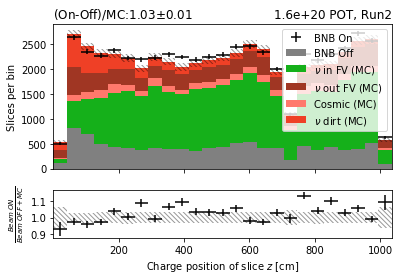

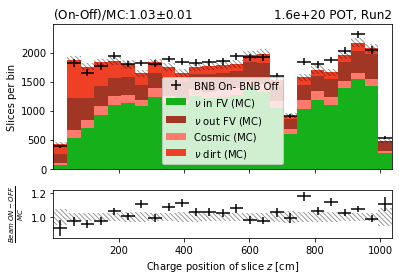

<IPython.core.display.Javascript object>

In [36]:
for i, (field, bins, x_min, x_max, x_axis) in enumerate(zip(*arrays)):
    for query in queries:
        fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
            "slices",
            field,
            x_min,
            x_max,
            bins,
            x_lab=x_axis,
            title_right=title_str,
            query=query,
        )
        for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
            ax[0].legend()
            fig.tight_layout()
            fig.savefig(
                outdir + "{}{}_{}.pdf".format(field, name, query), bbox_inches="tight"
            )

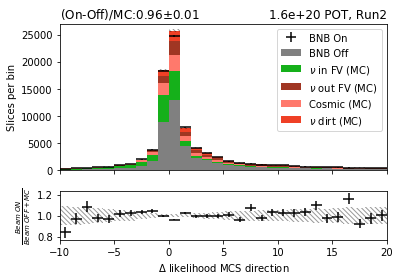

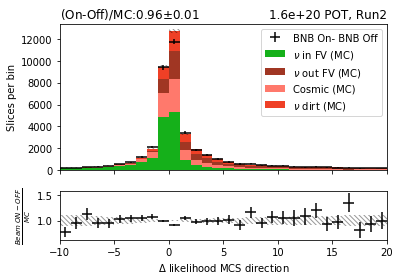

<IPython.core.display.Javascript object>

In [37]:
field = "maxDeltaLLMCS"
fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
    "slices",
    field,
    -10,
    20,
    30,
    x_lab="$\Delta$ likelihood MCS direction",
    title_right=title_str,
    query="passesPreCuts",
)
for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
    ax[0].legend()
    fig.tight_layout()
    fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

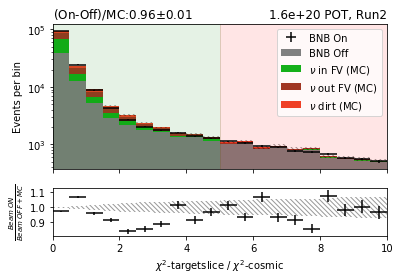

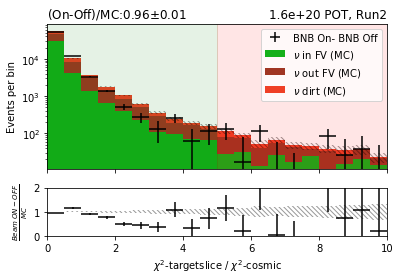

<IPython.core.display.Javascript object>

In [38]:
field = "bestCosmicMatchRatio"
fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
    "events",
    field,
    0,
    10,
    20,
    x_lab=r"$\chi^2$-targetslice / $\chi^2$-cosmic",
    title_right=title_str,
    query="nSlicesAfterPrecuts",
)
for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
    ax[0].legend()
    ax[0].set_yscale("log")
    ax[0].axvspan(0, 5, alpha=0.1, color="green")
    ax[0].axvspan(5, 10, alpha=0.1, color="red")
    fig.tight_layout()
    fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

nu_mu cc targetSliceMethod
-1    0.158792
 0    0.727002
 1    0.098383
 2    0.015823
Name: scale, dtype: float64
nu_e cc targetSliceMethod
-1    0.158256
 0    0.735344
 1    0.093060
 2    0.013340
Name: scale, dtype: float64


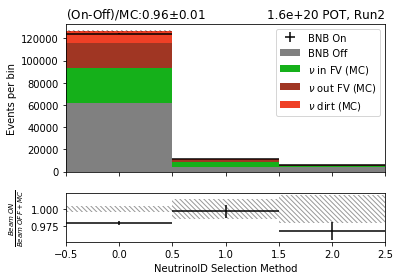

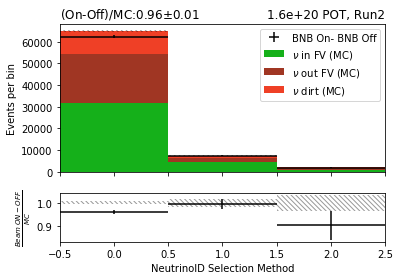

<IPython.core.display.Javascript object>

In [39]:
# Target Method = 0 -> Only one slice after precuts
# Target Method = 1 -> Slice with best topo score survived
# Target Method = 2 -> Slice needed flashmatching
field = "targetSliceMethod"
fig_arr, ax_arr, ksp, ratio = plotter.data_mc_plot_both(
    "events",
    field,
    -0.5,
    2.5,
    3,
    x_lab=r"NeutrinoID Selection Method",
    title_right=title_str,
    query="foundATargetSlice",
)
for ax, fig, name in zip(ax_arr, fig_arr, ["", "_diff"]):
    ax[0].legend()
    fig.tight_layout()
    fig.savefig(outdir + field + name + ".pdf", bbox_inches="tight")

print(
    "nu_mu cc",
    df_nu_sig.groupby("targetSliceMethod")["scale"].sum()
    / df_nu_sig.eval("scale").sum(),
)
print(
    "nu_e cc",
    df_nue_sig.groupby("targetSliceMethod")["scale"].sum()
    / df_nue_sig.eval("scale").sum(),
)

0.0	off: 99%	nue: 99.6%, 	nu: 99.5%
1.0	off: 38%	nue: 8.2%, 	nu: 11.9%
2.0	off: 28%	nue: 3.1%, 	nu: 4.3%
3.0	off: 23%	nue: 1.4%, 	nu: 2.3%
4.0	off: 19%	nue: 1.0%, 	nu: 1.4%
5.0	off: 16%	nue: 0.7%, 	nu: 1.0%
6.0	off: 14%	nue: 0.6%, 	nu: 0.7%
7.0	off: 12%	nue: 0.5%, 	nu: 0.5%


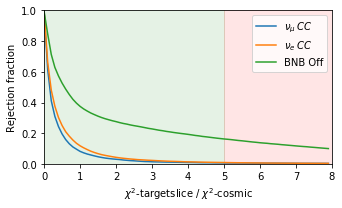

<IPython.core.display.Javascript object>

In [40]:
# Document the effect of the best cosmic matching ratio cut!
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3 * plotter.gr, 3))


mask_e = file_dict["off"]["events"]["targetSliceMethod"] > -1
chi_cosmic_nue = df_nue_sig.query("targetSliceMethod>-1")["bestCosmicMatchRatio"]
chi_cosmic_nu = df_nu_sig.query("targetSliceMethod>-1")["bestCosmicMatchRatio"]
chi_cosmic_off = file_dict["off"]["events"]["bestCosmicMatchRatio"][mask_e]

nu_pass = []
nue_pass = []
off_pass = []
for cut in np.arange(0, 8, 0.1):
    a = sum(chi_cosmic_nu > cut) / len(chi_cosmic_nu)
    b = sum(chi_cosmic_nue > cut) / len(chi_cosmic_nue)
    c = sum(chi_cosmic_off > cut) / len(chi_cosmic_off)
    nu_pass.append(a)
    nue_pass.append(b)
    off_pass.append(c)
    if cut % 1 == 0:
        print(
            "{0:0.1f}\toff: {1:0.0f}%\tnue: {2:0.1f}%, \tnu: {3:0.1f}%".format(
                cut, c * 100, a * 100, b * 100
            )
        )

ax.plot(np.arange(0, 8, 0.1), nu_pass, label=r"$\nu_\mu \: CC$")
ax.plot(np.arange(0, 8, 0.1), nue_pass, label=r"$\nu_e \: CC$")
ax.plot(np.arange(0, 8, 0.1), off_pass, label="BNB Off")
ax.set_ylim(0, 1)
ax.set_xlim(0, 8)
ax.axvspan(0, 5, alpha=0.1, color="green")
ax.axvspan(5, 8, alpha=0.1, color="red")
ax.set_xlim(0, 8)
ax.legend()
ax.set_xlabel(r"$\chi^2$-targetslice / $\chi^2$-cosmic")
ax.set_ylabel("Rejection fraction")
fig.tight_layout()
fig.savefig(outdir + "flashmatch_ratio_rejection.pdf", bbox_inches="tight")

In [ ]:
# Flash PE of selected slices in different bins of x!

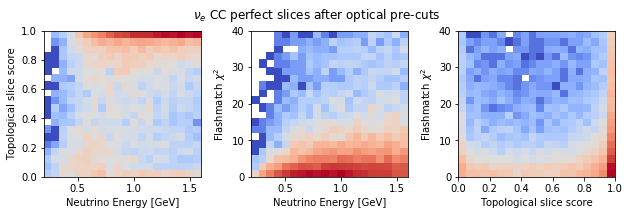

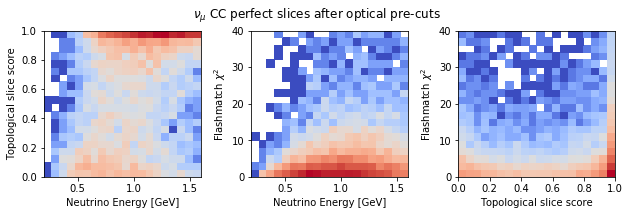

<IPython.core.display.Javascript object>

In [41]:
for l, (lab, v) in enumerate(sig_slices.items()):
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(5.5 * plotter.gr, 3))

    df_view = v.query(clean_query + " & + passesPreCuts")
    sig_E = df_view["nuEnergy"]
    sig_chi2 = df_view["topologicalScore"]
    sig_topo = df_view["flashMatchScore"]
    plot_data = [sig_E, sig_chi2, sig_topo]
    plot_labs = [
        "Neutrino Energy [GeV]",
        "Topological slice score",
        r"Flashmatch $\chi^2$",
    ]
    plot_min = [0.2, 0, 0]
    plot_max = [1.6, 1, 40]

    for i, (j, k) in enumerate([(0, 1), (0, 2), (1, 2)]):
        ax[i].hist2d(
            plot_data[j],
            plot_data[k],
            cmap="coolwarm",
            range=[[plot_min[j], plot_max[j]], [plot_min[k], plot_max[k]]],
            bins=[20, 20],
            norm=colors.LogNorm(),
        )
        ax[i].set_xlabel(plot_labs[j])
        ax[i].set_ylabel(plot_labs[k])

    # ax[2].add_patch(patches.Rectangle((0, 10), 0.25, 40, alpha=0.3, color="k"))
    # ax[2].add_patch(patches.Rectangle((0, 0), 0.06, 10, alpha=0.3, color="k"))
    fig.suptitle(lab + " perfect slices after optical pre-cuts")
    fig.tight_layout()
    fig.subplots_adjust(top=0.87)
    fig.savefig(outdir + "2d_topo_chi2_{}.pdf".format(l))

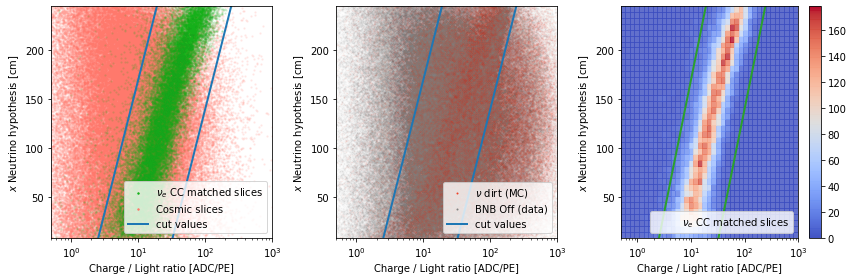

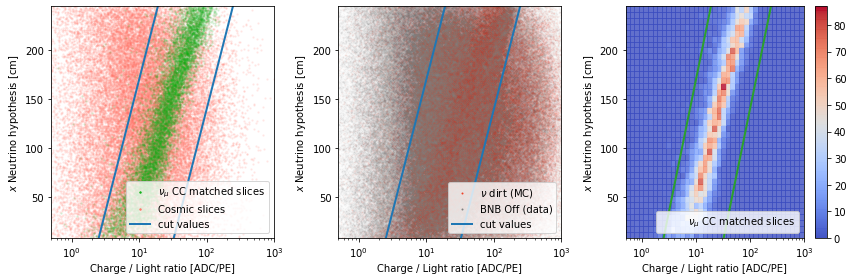

<IPython.core.display.Javascript object>

In [43]:
# Scatterplot to see xdependence on the charge light ratio!
for i, (lab, v) in enumerate(sig_slices.items()):
    df_good = v.query(clean_query)
    df_bad = v.query(bad_query)

    labels = ["Cosmic slices", lab + " matched slices"]

    N = 1000000
    m_xcl = 270

    field = "chargeToLightRatio"
    x_good = df_good[field].head(N)
    x_bad = df_bad[field].head(N)
    x_data = [x_bad, x_good]
    x_off = file_dict["off"]["slices"][field]
    x_dirt = file_dict["dirt"]["slices"][field]
    x_max = 1000
    x_min = 0.5
    x_bins = 40
    x_edges = np.logspace(np.log10(x_min), np.log10(x_max), x_bins)

    field = "centerX"
    y_good = df_good[field].head(N)
    y_bad = df_bad[field].head(N)
    y_data = [y_bad, y_good]
    y_off = file_dict["off"]["slices"][field]
    y_dirt = file_dict["dirt"]["slices"][field]
    y_max = helper.fid_box[0][1]  # helper.tpc_box[0][1]
    y_min = helper.fid_box[0][0]  # helper.tpc_box[0][0]
    y_bins = 40
    y_edges = np.linspace(y_min, y_max, y_bins)

    fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
    for x_arr, y_arr, lab, col in zip(
        x_data, y_data, labels, ["xkcd:salmon", "xkcd:green"]
    ):
        ax[0].scatter(x_arr, y_arr, s=2, alpha=0.1, label=lab, color=col)

    mids_x = 0.5 * (x_edges[1:] + x_edges[:-1])
    ax[0].plot(
        mids_x, m_xcl * np.log10(mids_x) - 100, color="C0", lw=2, label="cut values"
    )
    ax[0].plot(mids_x, m_xcl * np.log10(mids_x) - 400, color="C0", lw=2)

    handles, labelss = ax[0].get_legend_handles_labels()
    leg = ax[0].legend(handles[::-1], labelss[::-1], loc="lower right")
    for lh in leg.legendHandles:
        lh.set_alpha(1)

    for x_arr, y_arr, lab, col in zip(
        [x_off, x_dirt],
        [y_off, y_dirt],
        ["BNB Off (data)", r"$\nu$ dirt (MC)"],
        ["grey", "xkcd:tomato"],
    ):
        ax[1].scatter(x_arr, y_arr, s=1, alpha=0.03, label=lab, color=col)

    ax[1].plot(
        mids_x, m_xcl * np.log10(mids_x) - 100, color="C0", lw=2, label="cut values"
    )
    ax[1].plot(mids_x, m_xcl * np.log10(mids_x) - 400, color="C0", lw=2)

    handles, labelss = ax[1].get_legend_handles_labels()
    leg = ax[1].legend(handles[::-1], labelss[::-1], loc="lower right")
    for lh in leg.legendHandles:
        lh.set_alpha(1)

    ax[0].set_xscale("log", nonposx="clip")
    ax[0].set_xlim(x_min, x_max)
    ax[1].set_xscale("log", nonposx="clip")
    ax[1].set_xlim(x_min, x_max)

    ax[0].set_xlabel("Charge / Light ratio [ADC/PE]")
    ax[1].set_xlabel("Charge / Light ratio [ADC/PE]")
    ax[2].set_xlabel("Charge / Light ratio [ADC/PE]")
    ax[0].set_ylabel(r"$x$ Neutrino hypothesis [cm]")
    ax[1].set_ylabel(r"$x$ Neutrino hypothesis [cm]")
    ax[2].set_ylabel(r"$x$ Neutrino hypothesis [cm]")

    h, _, _ = np.histogram2d(x_good, y_good, bins=(x_edges, y_edges))
    X, Y = np.meshgrid(x_edges, y_edges)
    im = ax[2].pcolormesh(X, Y, h.T, cmap="coolwarm", alpha=0.8)
    clb = fig.colorbar(im, ax=ax[2])
    ax[2].set_xscale("log")
    ax[0].set_ylim(y_min, y_max)
    ax[1].set_ylim(y_min, y_max)
    ax[2].set_ylim(y_min, y_max)
    ax[2].plot([], [], " ", label=labels[1])
    ax[2].legend(loc="lower right")
    ax[2].plot(
        mids_x, m_xcl * np.log10(mids_x) - 100, color="C2", lw=2, label="new cut"
    )
    ax[2].plot(mids_x, m_xcl * np.log10(mids_x) - 400, color="C2", lw=2)

    fig.tight_layout()
    fig.savefig(
        outdir + "scatter_x_charge_light_{}.png".format(i), bbox_inches="tight", dpi=200
    )

### Sandbox